<a href="https://colab.research.google.com/github/pandian-raja/Oral_Disease_Detection/blob/main/Oral_Disease_Detection/Ipynb/OralDiagnosisConvertModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conversion of [Automatic detection of oral cancer in smartphone-based images using deep learning for early diagnosis](https://pubmed.ncbi.nlm.nih.gov/34453419/) paper into CoreML

Source code: https://github.com/hplin6/oral_disease_diagnosis

Connect Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import files from Google Drive

In [ ]:
# unzip Model weight 
!mkdir model_weight
!unzip '/content/drive/MyDrive/OralCancer/pretrained.zip' -d '/content/model_weight/'
# unzip code
!unzip '/content/drive/MyDrive/OralCancer/oral.zip' -d '/content/'
# images
!mkdir images
!unzip '/content/drive/MyDrive/OralCancer/images.zip' -d '/content/images/'

Archive:  /content/drive/MyDrive/OralCancer/pretrained.zip
  inflating: /content/model_weight/trained models/hrnetv2_w18_imagenet_pretrained.pth  
  inflating: /content/model_weight/trained models/cls_hrnet-v4_4-18-19_tcv.pth  
  inflating: /content/model_weight/trained models/cls_hrnet-v4_7-29-6_tt.pth  
  inflating: /content/model_weight/trained models/hrnetv2_w32_imagenet_pretrained.pth  
Archive:  /content/drive/MyDrive/OralCancer/oral.zip
   creating: /content/oral/
  inflating: /content/__MACOSX/._oral  
   creating: /content/oral/tools/
  inflating: /content/__MACOSX/oral/._tools  
  inflating: /content/oral/LICENSE   
  inflating: /content/__MACOSX/oral/._LICENSE  
   creating: /content/oral/experiments/
  inflating: /content/__MACOSX/oral/._experiments  
   creating: /content/oral/output/
  inflating: /content/__MACOSX/oral/._output  
  inflating: /content/oral/README.md  
  inflating: /content/__MACOSX/oral/._README.md  
   creating: /content/oral/samples/
  inflating: /conte

Install packages

In [ ]:
!pip install yacs
!pip install coremltools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.9 MB/s eta 0:00:00


Import packages

In [ ]:
from PIL import Image
import torch
import torch.onnx
import coremltools as ct
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import shutil
import matplotlib.pyplot as plt
import numpy as np

import oral.lib.models.cls_hrnet
from oral.lib.config import config
from oral.lib.models import cls_hrnet
shutil.rmtree('/content/images/__MACOSX')

Update congiguration from from yaml

In [ ]:
config = config
cfgPath = '/content/oral/experiments/cls_hrnet_w32_sgd_lr5e-2_wd1e-4_bs32_x100.yaml'
config.defrost()
config.merge_from_file(cfgPath)
config.freeze()

Create model and update weight

In [ ]:
model = cls_hrnet.HighResolutionNet(config)
model.init_weights("/content/model_weight/trained models/hrnetv2_w32_imagenet_pretrained.pth")
model.eval()

HighResolutionNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inpla

Create dataloader from images folder

In [ ]:
valdir = '/content/images/'
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
dataset = datasets.ImageFolder(valdir, transforms.Compose([transforms.Resize(int(config.MODEL.IMAGE_SIZE[0])),
                                                                                            transforms.ToTensor(),
                                                                                            normalize,]))
valid_loader = torch.utils.data.DataLoader(dataset,
                                           batch_size=1,#config.TEST.BATCH_SIZE_PER_GPU*len(gpus),
                                           shuffle=False,
                                           num_workers=1,
                                           pin_memory=True)

Predict sample data

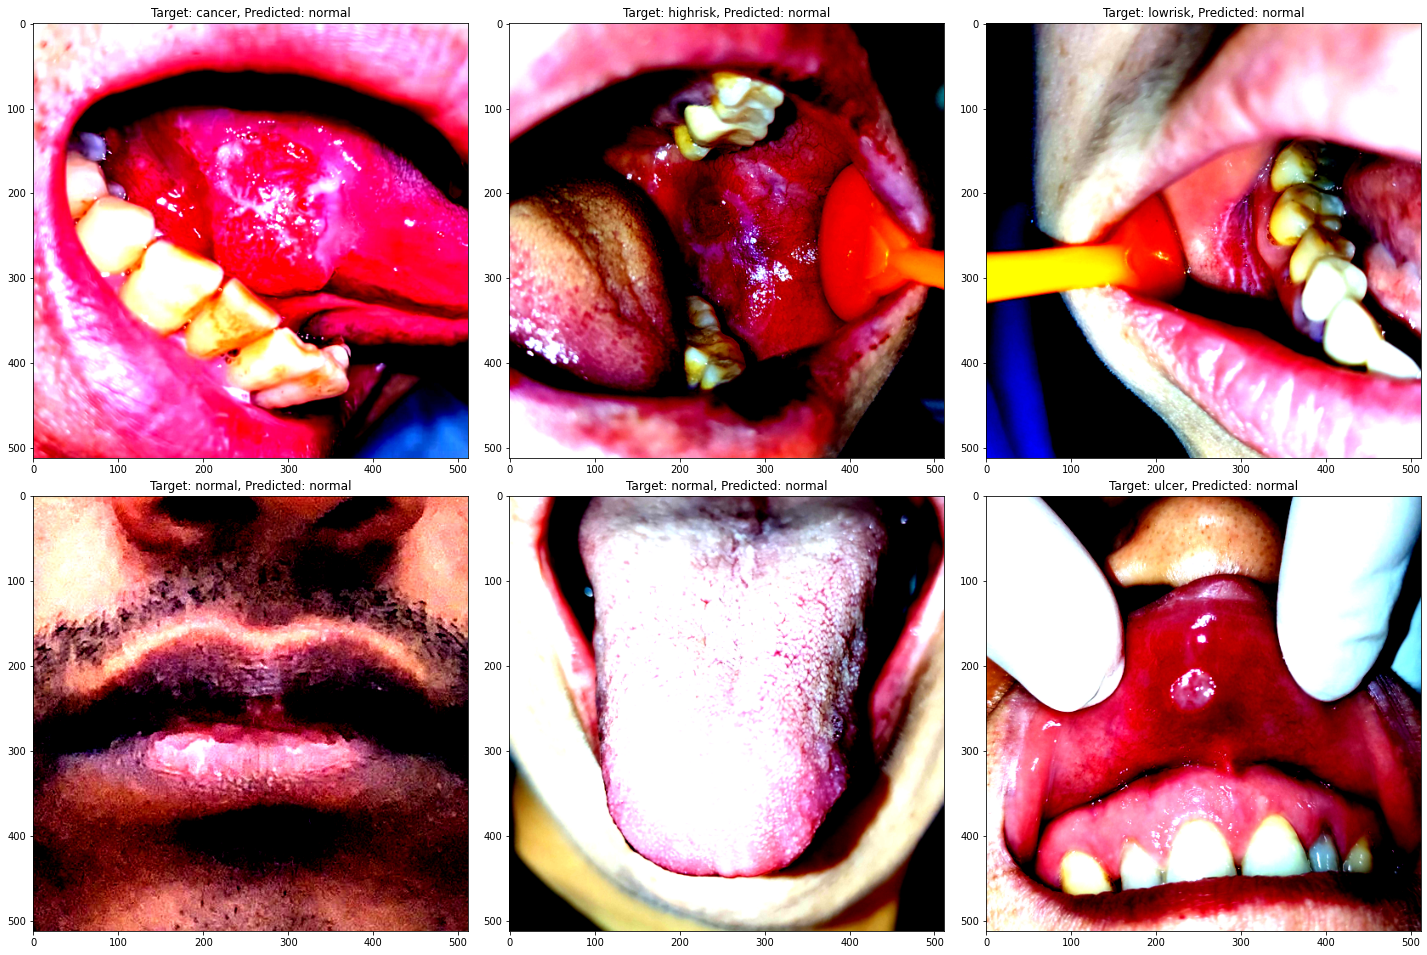

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 20))
fig.tight_layout() 

for i, (input, target) in enumerate(valid_loader):
  output = model(input)
  pred_class = output.argmax(dim=1, keepdim=False)  # get the index of the max log-probability
  x = np.squeeze(input)
  img = x.permute(1, 2, 0).numpy()
  plt.subplot(3, 3, i + 1)
  plt.title("Target: {}, Predicted: {}".format(dataset.classes[int(target)],dataset.classes[int(pred_class)]))
  plt.imshow(img)
plt.show()

# **Analysis:**
# It seems the model predicts everything as normal (No Cancer). Anyways convet to CoreML and test the model on iOS devices. 

ImageType as input layer for CoreML model

In [ ]:
#Reference: https://coremltools.readme.io/docs/convert-a-torchvision-model-from-pytorch#preprocess-the-image-input-for-torchvision-models
example_input = torch.rand(1, 3, 512, 512) 
image_input = ct.ImageType(name="input_1",shape=example_input.shape)


Convert pytorch model to CoreML model

In [ ]:
#Reference: https://coremltools.readme.io/docs/convert-a-torchvision-model-from-pytorch
traced_model = torch.jit.trace(model, example_input)
out = traced_model(example_input)
model = ct.convert(
    traced_model,
    inputs=[image_input], # change input layer (1, 3, 512, 512) to coremltools's ImageType 
    compute_units=ct.ComputeUnit.ALL, # Use both CPU and GPU on iOS devices
)

Running MIL Common passes:   8%|▊         | 3/40 [00:00<00:01, 28.74 passes/s]/usr/local/lib/python3.8/dist-packages/coremltools/converters/mil/mil/passes/name_sanitization_utils.py:135: UserWarning: Output, '5392', of the source model, has been renamed to 'var_5392' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 2854/2854 [00:06<00:00, 423.46 ops/s]


Save CoreML model to the google drive 

In [ ]:
model.save("/content/drive/MyDrive/OralCancer/Export/OralCancerV3.mlmodel")

In [ ]:

# Using image_input in the inputs parameter:
# Convert to Core ML program using the Unified Conversion API.
model = ct.convert(
    traced_model,
    convert_to="mlprogram",
    inputs=[image_input]
 )

Running MIL Common passes:   0%|          | 0/40 [00:00<?, ? passes/s]/usr/local/lib/python3.8/dist-packages/coremltools/converters/mil/mil/passes/name_sanitization_utils.py:135: UserWarning: Output, '5392', of the source model, has been renamed to 'var_5392' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Running MIL Clean up passes: 100%|██████████| 11/11 [00:39<00:00,  3.58s/ passes]


In [ ]:
model.save("/content/drive/MyDrive/OralCancer/Export/OralCancerV3.mlpackage")

In [ ]:
coreml_out_dict = model.predict({"input_1" : img})

Exception: ignored